In [1]:
from jaxgym.ode import odedopri,  electron_equation_of_motion_DA
from jaxgym.field import schiske_lens_expansion_xyz, obtain_first_order_electrostatic_lens_properties
import jaxgym.components as comp
from jaxgym.ray import Ray
from jaxgym.run import run_to_end, calculate_derivatives
from jaxgym.taylor import poly_dict, order_indices, poly_dict_to_sympy_expr

import jax
import jax.numpy as jnp
import numpy as np
import optimistix as optx

from scipy.constants import h as h_planck, e, m_e
from daceypy import array, DA
import sympy as sp
import os

from scipy.integrate import simpson

import matplotlib.pyplot as plt

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_LIMIT_MB"] = "400"

%matplotlib widget

/home/dl277493/JaxTemGym/src/jaxgym/ode.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


In [2]:
X, Y, Z = sp.symbols('X Y Z')

scale = 1 #set to mm scale
# Set Parameters for Schiske Electrostatic Lens
# Define lens parameters

z_init = -0.015*scale  # Convert m to um units
a = 0.0004*scale  # Convert m to um units
phi_0 = 10  # Volts

k = 0.4**(1/2)  # Unitless

(
    phi_expansion_symbolic,
    E_lambda, phi_lambda,
    phi_lambda_axial,
    phi_lambda_prime,
    phi_lambda_double_prime,
    phi_lambda_quadruple_prime,
    phi_lambda_sextuple_prime
) = schiske_lens_expansion_xyz(X, Y, Z, phi_0, a, k)

wavelength = h_planck/(2*abs(e)*m_e*phi_lambda_axial(z_init))**(1/2)*scale


z_pos, g, g_, h, h_, mag_real, z_image, z_focal_real, z_focal_asymp, z_pi = obtain_first_order_electrostatic_lens_properties(
    z_init, phi_lambda_axial, phi_lambda_prime, phi_lambda_double_prime, z_sampling=1000)

R_image_to_aperture = np.abs(z_init)
p_I = phi_lambda_axial(z_image)
p_O = phi_lambda_axial(z_init)

Uz0 = phi_lambda_axial(z_pos[0])

U_val = phi_lambda_axial(z_pos)
U_val_ = phi_lambda_prime(z_pos)
U_val__ = phi_lambda_double_prime(z_pos)
U_val____ = phi_lambda_quadruple_prime(z_pos)

def L_1():
    return (1/(32*jnp.sqrt(U_val)))*((U_val__**2)/(U_val)-U_val____)


def L_2():
    return (1/(8*jnp.sqrt(U_val)))*(U_val__)


def L_3():
    return 1/2*(jnp.sqrt(U_val))


def F_020():
    return (L_1()/4)*h*h*h*h + (L_2()/2)*h*h*h_*h_ + (L_3()/4)*h_*h_*h_*h_

Cs = 4/jnp.sqrt(abs(Uz0))*simpson(F_020(), x=z_pos)*mag_real
B = simpson(F_020(), x=z_pos)

print('Cs in metres (Aberration Integral Method):', Cs)
print('B in metres (Aberration Integral Method):', B)


Cs in metres (Aberration Integral Method): -110.45565402657013
B in metres (Aberration Integral Method): 52.30275456269711


In [3]:
print(Uz0)

9.997157576834251


In [4]:
order = 4

DA.init(order, 5)

# Set initial conditions. It does not matter that the slope and position are 0.
x0 = 0.
y0 = 0.
x0_slope = 0.0
y0_slope = 0.0
opl = 0.

z_init_nondm = z_init
z_image_nondm = z_image
print(z_init_nondm, z_image_nondm)

-0.015 0.02504562690667417


In [5]:

u0 = phi_lambda_axial(z_init)  # initial potential
x = array([x0 + DA(1), y0 + DA(2), x0_slope + DA(3), y0_slope + DA(4), opl + DA(5)])

# solve the equation of motion via the differential algebra method, which delivers the solution as a taylor expansion
with DA.cache_manager():
    zf, x_f = odedopri(electron_equation_of_motion_DA, 
                       x0 = z_init_nondm,
                       y0 = x, 
                       x1 = z_image_nondm,  
                       tol = 1e-1, 
                       hmax = 1000000, 
                       hmin = 1e-15,  
                       maxiter =int(1e5), 
                       args=(phi_lambda, E_lambda, u0))
    
Cs_daceypy = x_f[0].getCoefficient([0, 0, 3, 0])

  0%|          | 0/100000 [00:00<?, ?it/s]

z = 0.02504562690667417


In [6]:
Cs = 4/jnp.sqrt(abs(Uz0))*simpson(F_020(), x=z_pos)*mag_real
print('Cs (Aberration Integral Method):', Cs)
print('Cs (DA) - x polynomial', Cs_daceypy)
print('Cs (DA) - opl polynomial', x_f[4].getCoefficient([0, 0, 4, 0, ]) * 4 / 3 * mag_real)


Cs (Aberration Integral Method): -110.45565402657013
Cs (DA) - x polynomial -110.45567442824138
Cs (DA) - opl polynomial -110.4556744312192


In [7]:
z_init = jnp.array(z_init)
z_image = jnp.array(z_image)

PointSource = comp.InputPlane(z=z_init)
ElectrostaticLens = comp.ODE(z=z_init, z_end=z_image, phi_lambda=phi_lambda, E_lambda=E_lambda)
Detector = comp.Detector(z=z_image, det_pixel_size=(55e-6 * scale, 55e-6 * scale), det_shape = (256, 256))
model = [PointSource, ElectrostaticLens, Detector]

det_coords = Detector.get_coords()

In [8]:
ray = Ray(0., 0., 0., 0., 0., z_init, 0.0)
ray_out = run_to_end(ray, model)

derivatives = calculate_derivatives(ray, model, order)

In [9]:
selected_vars = ['x', 'y', 'dx', 'dy', 'pathlength']
multi_indices = order_indices(order, n_vars=len(selected_vars))

In [10]:
poly_dicts = poly_dict(derivatives, selected_vars, multi_indices[1:])

In [11]:
x_var, y_var, dx_var, dy_var, x_out, y_out, dx_out, dy_out, opl_var = sp.symbols("x y x' y' x_out y_out dx_out, dy_out S", real=True)
x_a, y_a = sp.symbols("x_a y_a", real=True)
polynomials = poly_dict_to_sympy_expr(poly_dicts, selected_vars, sym_vars=[x_var, y_var, dx_var, dy_var, opl_var])

Sxp = polynomials['pathlength']
x = polynomials['x']
Sxa = polynomials['pathlength'].subs({dx_var: (x_var - x_a / mag_real) / R_image_to_aperture, dy_var:  (y_var - y_a / mag_real) / R_image_to_aperture})

Sxp_coeff_xp4 = sp.Poly(Sxp, dx_var).coeff_monomial(dx_var**4)
Sxp_xp4 = sp.Eq(sp.symbols('dx_Sxp'), Sxp_coeff_xp4 * dx_var**4)
x_Sxp_xp3 = sp.Eq(sp.symbols('dx_Sxp'), Sxp_coeff_xp4 * dx_var**3 * 4 / 3 * mag_real)

x_coeff_xp3 = sp.Poly(x, dx_var).coeff_monomial(dx_var**3)
x_xp3 = sp.Eq(sp.symbols('dx_x'), x_coeff_xp3 * dx_var**3)

Sxa_coeff_xa4 = sp.Poly(Sxa, x_a).coeff_monomial(x_a**4)
Sxa_xa4 = sp.Eq(sp.symbols('W_a'), Sxa_coeff_xa4 * x_a**4)
x_xa3 = sp.Eq(sp.symbols('dx_Sxa'), sp.diff(Sxa_xa4.rhs, x_a) * R_image_to_aperture)


display(x_Sxp_xp3)
display(x_xp3)
display(x_xa3)
display(x_xa3.rhs.subs({x_a: -dx_var * mag_real * R_image_to_aperture}))

Eq(dx_Sxp, -110.455674423884*x'**3)

Eq(dx_x, -110.4556744365*x'**3)

Eq(dx_Sxa, 7574032.66565805*x_a**3)

118.912073552067*x'**3

In [12]:
wronskian = np.sqrt(p_I) * (g[-1] * h_[-1] - g_[-1] * h[-1])
print('Wronskian:', wronskian, np.sqrt(p_O))

T, deltaX = sp.symbols(r'T $dx$', real=True)
eq = sp.Eq(deltaX, (4 * B * mag_real ** 4) / (k ** 4))

T_sol = sp.solve(eq, T)
T = 4.76088625318678*(1/110.455674436522)**(1/4)

print('T:', 1/T)

Wronskian: 3.161828201695482 3.1618282016634383
T: 0.680940558319416


In [13]:


# Extract just the x'^4 term from polynomials['pathlength']


print(R_image_to_aperture)
x_from_aper_poly = sp.diff(Sxa, x_a)
x_from_aper_poly = x_from_aper_poly.subs({x_a: -dx_var, y_a: -dy_var})

display(x_from_aper_poly)
display(polynomials['x'])

0.015


6259389355.06911*x**3 + 12412019364.9471*x**2*(1.19808692482976*x - 0.717706139724017*x') + 6259389355.06912*x*y**2 + 148703375.764232*x*y*(66.6666666666667*y - 39.9362308276587*y') + 10961149841.2502*x*(x - 0.599043462414881*x')**2 + 3653716613.75009*x*(y - 0.599043462414881*y')**2 - 5.19031047247289e-9*x + 1.17280645429227e-9*x' + 4137529276.76689*y**2*(1.19808692482976*x - 0.717706139724017*x') + 91488769.4213653*y*(1.19808692482976*x - 0.717706139724017*x')*(66.6666666666667*y - 39.9362308276587*y') + 2348880465.22602*(x - 0.599043462414881*x')**3 + 1960525915.56309*(1.19808692482976*x - 0.717706139724017*x')*(y - 0.599043462414881*y')**2

-32682396.9228751*x**3 - 1471017.86810085*x**2*x' - 22075.4367990953*x*x'**2 - 32682396.9228752*x*y**2 - 980536.235490282*x*y*y' - 7358.47893311007*x*y'**2 - 1.66932795817787*x - 110.4556744365*x'**3 - 490481.63261057*x'*y**2 - 14716.9578659853*x'*y*y' - 110.4556744365*x'*y'**2 + 4.79157729119106e-13*x'

In [ ]:

polynomials['pathlength'] = polynomials['pathlength'].subs({opl_var: 0})
polynomials['pathlength'] = polynomials['pathlength']
phase = 2 * np.pi * (polynomials['pathlength'] / wavelength)

dSdxodxp = sp.diff(polynomials['pathlength'], x_var, dx_var)
dSdxodyp = sp.diff(polynomials['pathlength'], x_var, dy_var)
dSdyodxp = sp.diff(polynomials['pathlength'], y_var, dx_var)
dSdyodyp = sp.diff(polynomials['pathlength'], y_var, dy_var)

hessian = sp.Matrix([[dSdxodxp, dSdxodyp], [dSdyodxp, dSdyodyp]])
amplitude = sp.sqrt(hessian.det())
amplitude = sp.lambdify([x_var, y_var, dx_var, dy_var], amplitude, modules='numpy')


383919806.741232*sqrt(0.500000000000001*x**4 + 0.0237571223015666*x**3*x' + 0.000413536921691142*x**2*x'**2 + x**2*y**2 + 0.0237571223015666*x**2*y*y' + 0.000124823034619979*x**2*y'**2 - 3.44284049169572e-19*x**2 + 3.12017709603125e-6*x*x'**3 + 0.0237571223015666*x*x'*y**2 + 0.000577427774142327*x*x'*y*y' + 3.12017709603125e-6*x*x'*y'**2 - 8.17924508862344e-21*x*x' + 8.62463702633984e-9*x'**4 + 0.000124823034619979*x'**2*y**2 + 3.12017709603125e-6*x'**2*y*y' + 1.72492740526796e-8*x'**2*y'**2 - 4.52170591670086e-23*x'**2 + 0.500000000000001*y**4 + 0.0237571223015666*y**3*y' + 0.000413536921691142*y**2*y'**2 - 3.44284049169572e-19*y**2 + 3.12017709603125e-6*y*y'**3 - 8.17924508862344e-21*y*y' + 8.62463702633984e-9*y'**4 - 4.52170591670086e-23*y'**2 + 4.44493149422235e-38)

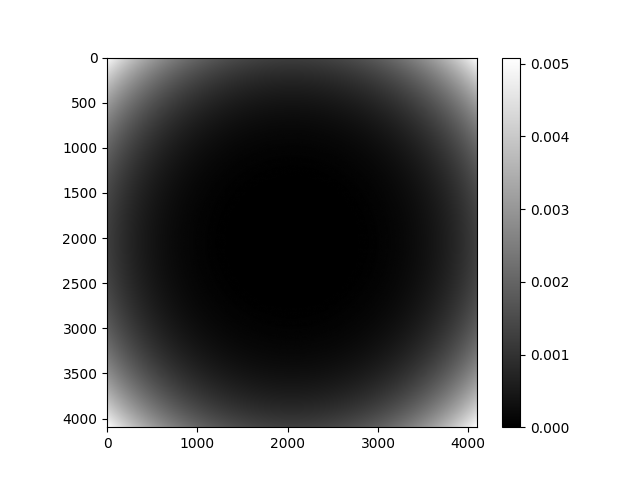

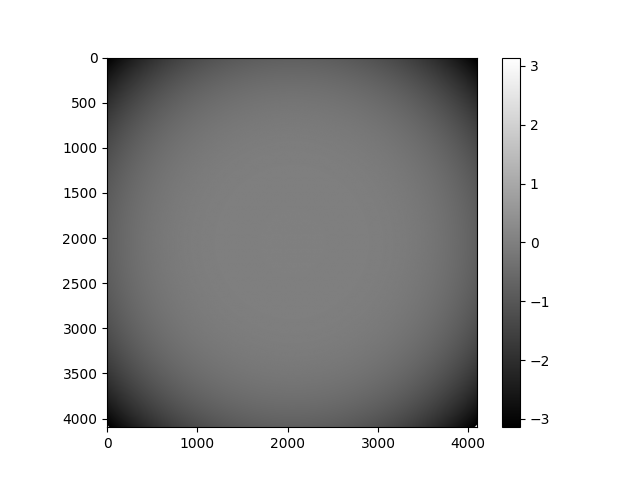

In [18]:
max_slope = 1e-3
num_px = 4096
x_pos = y_pos = 0e-6

q_x = np.linspace(-max_slope, max_slope, num_px)
q_y = np.linspace(-max_slope, max_slope, num_px)

q_x, q_y = np.meshgrid(q_x, q_y)
q_x = q_x.flatten()
q_y = q_y.flatten()

phase_eval = sp.lambdify((x_var, y_var, dx_var, dy_var), phase, modules='numpy')
phase_vals = phase_eval(x_pos, y_pos, abs(q_x), abs(q_y))
phase_vals = np.array(phase_vals, dtype=np.float64)

phase_vals = phase_vals.reshape((num_px, num_px))
phase_vals = np.exp(-1j * phase_vals)

amp_vals = amplitude(x_pos, y_pos, abs(q_x), abs(q_y))
amp_vals = np.array(amp_vals, dtype=np.float64)
amp_vals = amp_vals.reshape((num_px, num_px))

wave_response = amp_vals * phase_vals

plt.figure()
plt.imshow(np.angle(wave_response), cmap='gray')
plt.colorbar()

plt.figure()
plt.imshow(np.abs(wave_response)**2, cmap='gray')
plt.colorbar()
plt.show()


Convert polynomials from function of input slope to function of aperture. Replace everywhere x' with x_a and y' with y_a.

For this we will simply say that x_a = x_o' * R where R is the distance to the aperture

In [105]:
jax_poly_x = sp.lambdify([u, v, w, q], polynomials['x'], modules='jax')
jax_poly_y = sp.lambdify([u, v, w, q], polynomials['y'], modules='jax')
jax_poly_opl = sp.lambdify([u, v, w, q], opl, modules='jax')

NameError: name 'u' is not defined

In [ ]:
jax_poly_opl(0.5, 0.5, 0.1, 0.1)

7.355877139820936e-10

In [ ]:
# flatten detector coordinates
x_out_flat = det_coords[:, 0].ravel()
y_out_flat = det_coords[:, 1].ravel()

input_x = 1
input_y = 1

max_slope = 0.1


def input_slope_from_image_position(params, args):
    dx, dy = params           # params is a rank-1 array of length 2
    x_in, y_in, x_out, y_out = args
    res_x = jax_poly_x(x_in, y_in, dx, dy) - x_out 
    res_y = jax_poly_y(x_in, y_in, dx, dy) - y_out
    return jnp.stack([res_x, res_y])

solver = optx.Newton(rtol=1e-10, atol=1e-10)
params = jnp.array([0.0, 0.0])  # initial guess for dx and dy

# define a helper that for each output‐pixel finds the input slopes and evaluates the polys
def compute_at_pixel(xo, yo):
    sol = optx.root_find(input_slope_from_image_position,
                         solver,
                         params,
                         (input_x, input_y, xo, yo)).value
    dx, dy = sol[0], sol[1]

    amp = amplitude(input_x, input_y, dx, dy)
    opl = jax_poly_opl(input_x, input_y, dx, dy)
    return amp, opl

# vmap over all flattened pixels
compute_batch = jax.vmap(compute_at_pixel, in_axes=(0, 0))
amp, opl = compute_batch(x_out_flat, y_out_flat)

amp = amp.reshape(Detector.det_shape)
opl = opl.reshape(Detector.det_shape)

In [ ]:
phase = np.angle(np.exp(1j * (2 * np.pi / wavelength) * opl))

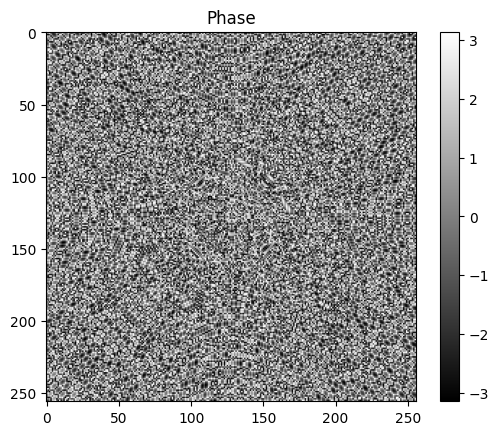

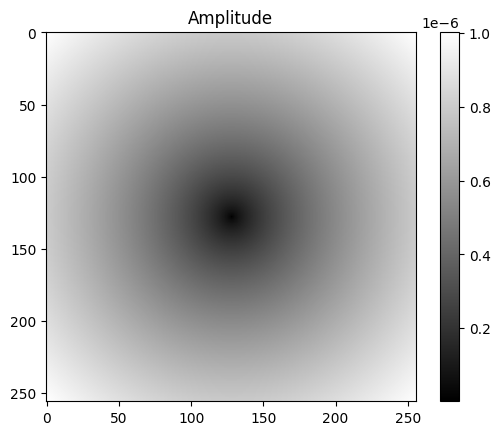

In [ ]:
plt.figure()
plt.imshow(phase, cmap='gray')
plt.colorbar()
plt.title('Phase')

plt.figure()
plt.imshow(amp, cmap='gray')
plt.colorbar()
plt.title('Amplitude')
plt.show()

In [178]:
var = 'pathlength'

if var == 'x':
    var_idx = 0
elif var == 'y':
    var_idx = 1
elif var == 'dx':
    var_idx = 2
elif var == 'dy':
    var_idx = 3
elif var == 'pathlength':
    var_idx = 4
else:
    raise ValueError(f"Unknown variable: {var}")

header = f"{'I':>6}  {'COEFFICIENT':>3}   {'ORDER':>16} {'EXPONENTS':>4}"
const = f"{1:6d}   {getattr(ray_out, var): .16e}   {0} {'  0  0  0  0  0':15s}"

print_jax = [header, const]
for idx, entry in enumerate(poly_dicts[var]):
    exponents = tuple(map(int, entry[:-1]))
    coeff = entry[-1]
    total_order = sum(exponents)
    exponents_str = " ".join(f"{e:2d}" for e in exponents)
    print_jax.append(f"{idx:6d}   {coeff: .16e}   {total_order}  {exponents_str}")
print_jax.append('------------------------------------------------')


header = f"{'I':>6}  {'COEFFICIENT':>3}   {'ORDER':>16} {'EXPONENTS':>4}"
const = f"{1:6d}   {x_f[var_idx].getCoefficient([0, 0]): .16e}   {0} {'  0  0  0  0  0':15s}"

print_daceypy = [header, const]

for idx, entry in enumerate(poly_dicts[var]):
    exponents = tuple(map(int, entry[:-1]))
    coeff = x_f[var_idx].getCoefficient(list(exponents))
    total_order = sum(exponents)
    exponents_str = " ".join(f"{e:2d}" for e in exponents)
    print_daceypy.append(f"{idx:6d}   {coeff: .16e}   {total_order}  {exponents_str}")
print_daceypy.append('------------------------------------------------')

# Print the two blocks side by side
for left, right in zip(print_jax, print_daceypy):
    print(f"{left:<60} {right}")


     I  COEFFICIENT              ORDER EXPONENTS                  I  COEFFICIENT              ORDER EXPONENTS
     1    3.9788388116415080e-02   0   0  0  0  0  0              1    3.9788388116417134e-02   0   0  0  0  0  0
     0    1.0000000000000000e+00   1   0  0  0  0  1              0    1.0000000000000000e+00   1   0  0  0  0  1
     1   -3.5944478730259900e-13   2   0  0  0  2  0              1    8.9086873186587645e-14   2   0  0  0  2  0
     2   -7.8011347381945484e-11   2   0  1  0  1  0              2    2.8892464809526786e-11   2   0  1  0  1  0
     3   -3.5944478730259900e-13   2   0  0  2  0  0              3    8.9086873186587645e-14   2   0  0  2  0  0
     4   -7.8011347381945484e-11   2   1  0  1  0  0              4    2.8892464809526786e-11   2   1  0  1  0  0
     5    8.8932114098960284e+01   2   0  2  0  0  0              5    8.8932114104264912e+01   2   0  2  0  0  0
     6    8.8932114098960284e+01   2   2  0  0  0  0              6    8.8932114104264912e+0